In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

from distfit import distfit

from utils.constants import *

 - 0 : up_imbalance
 - 1 : balance
 - 2 : down_imbalance

In [4]:
start_index = HOURS_PER_YEAR - HOURS_PER_DAY
training_length = HOURS_PER_MONTH
testing_length = HOURS_PER_DAY

In [5]:
dataframe = pd.read_csv('2022_2023/2022_2023_data.csv', index_col=0)
dataframe['price_diff'] = dataframe['prices_SB'] - dataframe['forward_RE']
dataframe['balancing_state'] = np.where(dataframe['price_diff'] > 0, 0, np.where(dataframe['price_diff'] < 0, 2, 1))
balancing_states = dataframe['balancing_state'].values
# Store in another array the duration of each state
durations = np.zeros_like(balancing_states)
# Print the first 10 states
print("States:\n")
print(balancing_states[:10])
display(dataframe.head(10))

States:

[1 1 1 1 1 1 1 2 2 2]


,forward_RE,forward_FC,prices_SB,production_RE,production_FC,Offshore DK2,Offshore DK1,Onshore DK2,Onshore DK1,price_diff,balancing_state
0,41.33,57.547726,41.33,0.995098,1.000000,0.274701,0.506045,0.680247,0.659599,0.00,1
1,42.18,42.775177,42.18,1.000000,1.000000,0.356135,0.541451,0.796296,0.671060,0.00,1
2,44.37,69.404847,44.37,1.000000,0.776486,0.279045,0.219344,0.728395,0.638109,0.00,1
3,37.67,39.025886,37.67,0.995098,0.935938,0.228013,0.201209,0.698765,0.619771,0.00,1
4,39.70,61.991515,39.70,1.000000,1.000000,0.221498,0.201209,0.690123,0.604011,0.00,1
5,40.59,39.462294,40.59,0.995098,0.986932,0.221498,0.201209,0.687654,0.613754,0.00,1
6,43.26,48.842056,43.26,0.995098,1.000000,0.221498,0.199482,0.719753,0.663897,0.00,1
7,49.66,48.002595,43.14,0.995098,0.964787,0.228013,0.201209,0.662963,0.652722,-6.52,2
8,70.05,66.866305,43.13,1.000000,1.000000,0.386536,0.199482,0.690123,0.651003,-26.92,2
9,76.79,77.209486,50.00,1.000000,0.803111,0.386536,0.195164,0.682716,0.755874,-26.79,2


In [6]:
# # Initialize the duration of the first state
# duration = 1
# durations[0] = duration
# # Iterate over the states to compute the duration of each state
# for i in range(1, len(balancing_states)):
#     if balancing_states[i] == balancing_states[i - 1]:
#         duration += 1
#         durations[i] = duration
#     else:
#         duration = 1
#         durations[i] = duration
# 
# # Store the duration of the last state
# 
# # Print the first 10 states and their durations
# print("\nStates and Durations:\n")
# print(np.vstack((balancing_states[:10], durations[:10])).T)
# 
# # Print the number of appearances of each duration divided by the duration
# print("\nDuration Counts:\n")
# print({duration: (durations == duration).sum() for duration in np.unique(durations)})


In [7]:
states = ['up_imbalance','balance','down_imbalance']
num_states = len(states)

In [8]:
def count_hour_specific_transition_matrices(states):
    # Initialize a dictionary to store the count of transitions for each duration
    transition_matrices = {hour: np.zeros((3, 3), dtype=int) for hour in range(24)}
    # Count transitions based on the hour
    for i in range(1, len(states)):
        transition_matrices[(i - 1) % 24][states[i - 1], states[i]] += 1
    # Normalize the count of transitions for each duration
    for hour, transition_counts in transition_matrices.items():
        transition_matrices[hour] = transition_counts / transition_counts.sum(axis=1, keepdims=True)
    return transition_matrices

# Count and normalize hour-specific state transitions
transition_matrices = count_hour_specific_transition_matrices(balancing_states[start_index - training_length:start_index])

print("Hour-Specific Transition Matrices:\n")
for hour, matrix in transition_matrices.items():
    print(f"Hour {hour}:\n{matrix}\n")

Hour-Specific Transition Matrices:

Hour 0:
[[0.85714286 0.         0.14285714]
 [0.         0.85714286 0.14285714]
 [0.11111111 0.11111111 0.77777778]]

Hour 1:
[[0.76923077 0.23076923 0.        ]
 [0.14285714 0.85714286 0.        ]
 [0.1        0.1        0.8       ]]

Hour 2:
[[0.83333333 0.         0.16666667]
 [0.1        0.7        0.2       ]
 [0.         0.         1.        ]]

Hour 3:
[[0.72727273 0.27272727 0.        ]
 [0.         0.85714286 0.14285714]
 [0.         0.         1.        ]]

Hour 4:
[[0.5        0.375      0.125     ]
 [0.33333333 0.33333333 0.33333333]
 [0.         0.30769231 0.69230769]]

Hour 5:
[[0.85714286 0.14285714 0.        ]
 [0.5        0.2        0.3       ]
 [0.15384615 0.23076923 0.61538462]]

Hour 6:
[[0.76923077 0.15384615 0.07692308]
 [0.16666667 0.5        0.33333333]
 [0.         0.09090909 0.90909091]]

Hour 7:
[[0.54545455 0.45454545 0.        ]
 [0.33333333 0.5        0.16666667]
 [0.07692308 0.07692308 0.84615385]]

Hour 8:
[[0.88888889

In [9]:
# Generate a sequence of states based on the transition matrix
def generate_states(num_steps, initial_state, initial_hour, transition_matrices):
    states = np.zeros(num_steps + 1, dtype=int)
    states[0] = initial_state
    hour = initial_hour
    for i in range(1, num_steps + 1):
        states[i] = np.random.choice(3, p=transition_matrices[hour][states[i - 1]])
        hour = (hour + 1) % 24
    return states[1:]

In [10]:
# Forecast the next 24 hours
num_steps = 24
current_state = balancing_states[start_index - 1]
duration = durations[start_index-1]
forecast = generate_states(num_steps, current_state, 0, transition_matrices)
# Generate the forecasted states multiple times and compute the average
num_forecasts = 2
forecasts = np.zeros((num_forecasts, num_steps))
for i in range(num_forecasts):
    forecasts[i] = generate_states(num_steps, current_state, 0, transition_matrices)
forecast = forecasts.mean(axis=0).astype(int)
print("Forecasted States:\n")
print(forecast)
print("\nReal States:\n")
print(balancing_states[start_index:start_index + num_steps])

Forecasted States:

[2 2 2 2 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 2]

Real States:

[2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2]


Forecast Accuracy: 0.39
Best Forecast Accuracy: 0.79


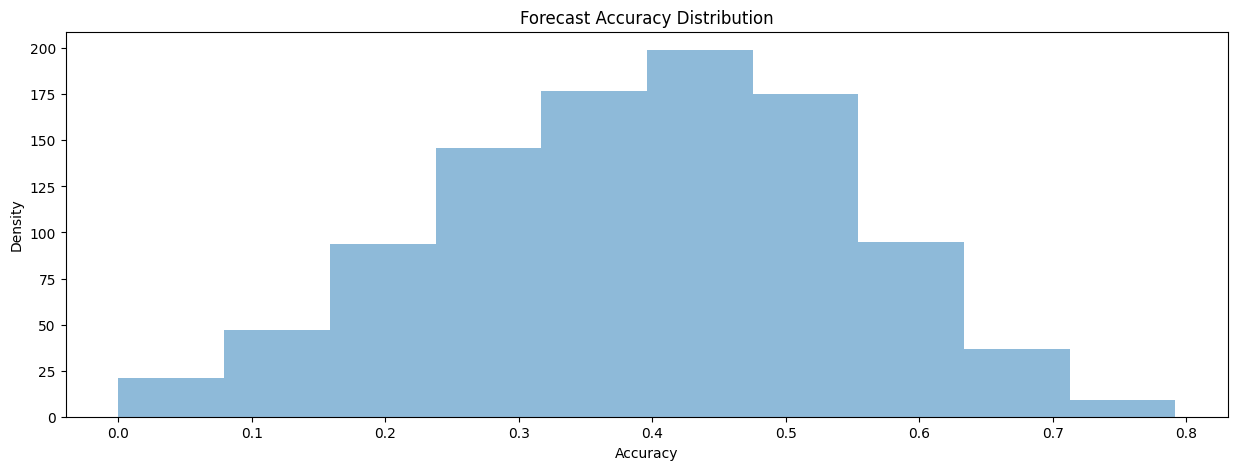

In [11]:
# Compute the accuracy of the forecast

accuracies = np.zeros(1000)
for i in range(1000):
    forecasts = generate_states(num_steps, current_state, 0, transition_matrices)
    accuracies[i] = np.mean((forecasts == balancing_states[start_index:start_index + num_steps]))
print(f"Forecast Accuracy: {accuracies.mean():.2f}")
print(f"Best Forecast Accuracy: {accuracies.max():.2f}")

plt.figure(figsize=(15, 5))
plt.hist(accuracies, bins=10, alpha=0.5)
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.title('Forecast Accuracy Distribution')
plt.show()

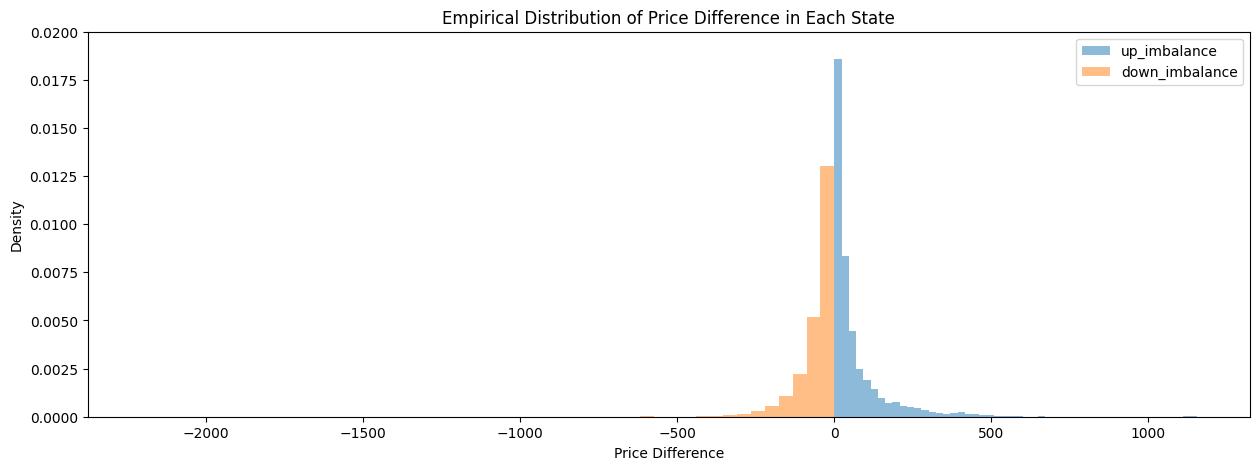

In [12]:
# Plot the empirical distribution of prices diff in each state

# Initialize a dictionary to store the prices diff in each state

prices_diff = {state: [] for state in range(3)}

# Iterate over the data to store the prices diff in each state

for i in range(1, len(balancing_states)):
    prices_diff[balancing_states[i]].append(dataframe['prices_SB'][i] - dataframe['forward_RE'][i])
    
# Plot the empirical distribution of prices diff in each state

plt.figure(figsize=(15, 5))
for state, diff in prices_diff.items():
    if state == 1:
        continue
    plt.hist(diff, bins=50, alpha=0.5, label=states[state],density=True)
plt.xlabel('Price Difference')
plt.ylabel('Density')
plt.ylim(0, 0.02)
plt.title('Empirical Distribution of Price Difference in Each State')
plt.legend()
plt.show()

In [20]:
import scipy.stats as stats

# Fit distributions to each state's data
shape_up, loc_up, scale_up = stats.lognorm.fit(prices_diff[0], floc=0)

dist_up = distfit()
dist_up.fit_transform(np.array(prices_diff[0], dtype=float))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000837309] [loc=68.386 scale=102.892]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.000172571] [loc=0.010 scale=68.376]
[distfit] >INFO> [pareto    ] [0.0 sec] [RSS: 6.58952e-06] [loc=-75.739 scale=75.749]
[distfit] >INFO> [dweibull  ] [0.22 sec] [RSS: 0.000728134] [loc=20.000 scale=42.729]
[distfit] >INFO> [t         ] [0.35 sec] [RSS: 0.000296644] [loc=22.049 scale=20.207]
[distfit] >INFO> [genextreme] [0.28 sec] [RSS: 2.60367e-05] [loc=17.781 scale=22.160]
[distfit] >INFO> [gamma     ] [0.17 sec] [RSS: 2.32222e-05] [loc=0.010 scale=79.118]
[distfit] >INFO> [lognorm   ] [0.0 sec] [RSS: 5.71237e-06] [loc=-0.849 scale=29.769]
[distfit] >INFO> [beta      ] [0.26 sec] [RSS: 5.3495e-05] [loc=0.010 scale=21091.579]
[distfit] >INFO> [uniform   ] [0.0 sec] [RSS: 0.00123385] [loc=0.010 scale=1155.380]
[distfit] >INFO> [loggamma  ] [0.06 sec] [RSS: 0.000851386] [loc=-35279.014 scale=4695.908]
[d

{'model': {'name': 'lognorm',
  'score': 5.712366609476092e-06,
  'loc': -0.8486279401720106,
  'scale': 29.769229389200714,
  'arg': (1.3860648417232988,),
  'params': (1.3860648417232988, -0.8486279401720106, 29.769229389200714),
  'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1711c412840>,
  'bootstrap_score': 0,
  'bootstrap_pass': None,
  'color': '#e41a1c',
  'CII_min_alpha': 2.196678420357234,
  'CII_max_alpha': 290.1588811607634},
 'summary':           name     score          loc         scale  \
 0      lognorm  0.000006    -0.848628     29.769229   
 1       pareto  0.000007   -75.739424     75.749424   
 2        gamma  0.000023         0.01     79.118163   
 3   genextreme  0.000026    17.781469     22.159532   
 4         beta  0.000053         0.01  21091.578994   
 5        expon  0.000173         0.01     68.375659   
 6            t  0.000297    22.049052     20.206883   
 7     dweibull  0.000728         20.0     42.728844   
 8         norm  0

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Lognorm(loc:-0.848628, scale:29.769229)


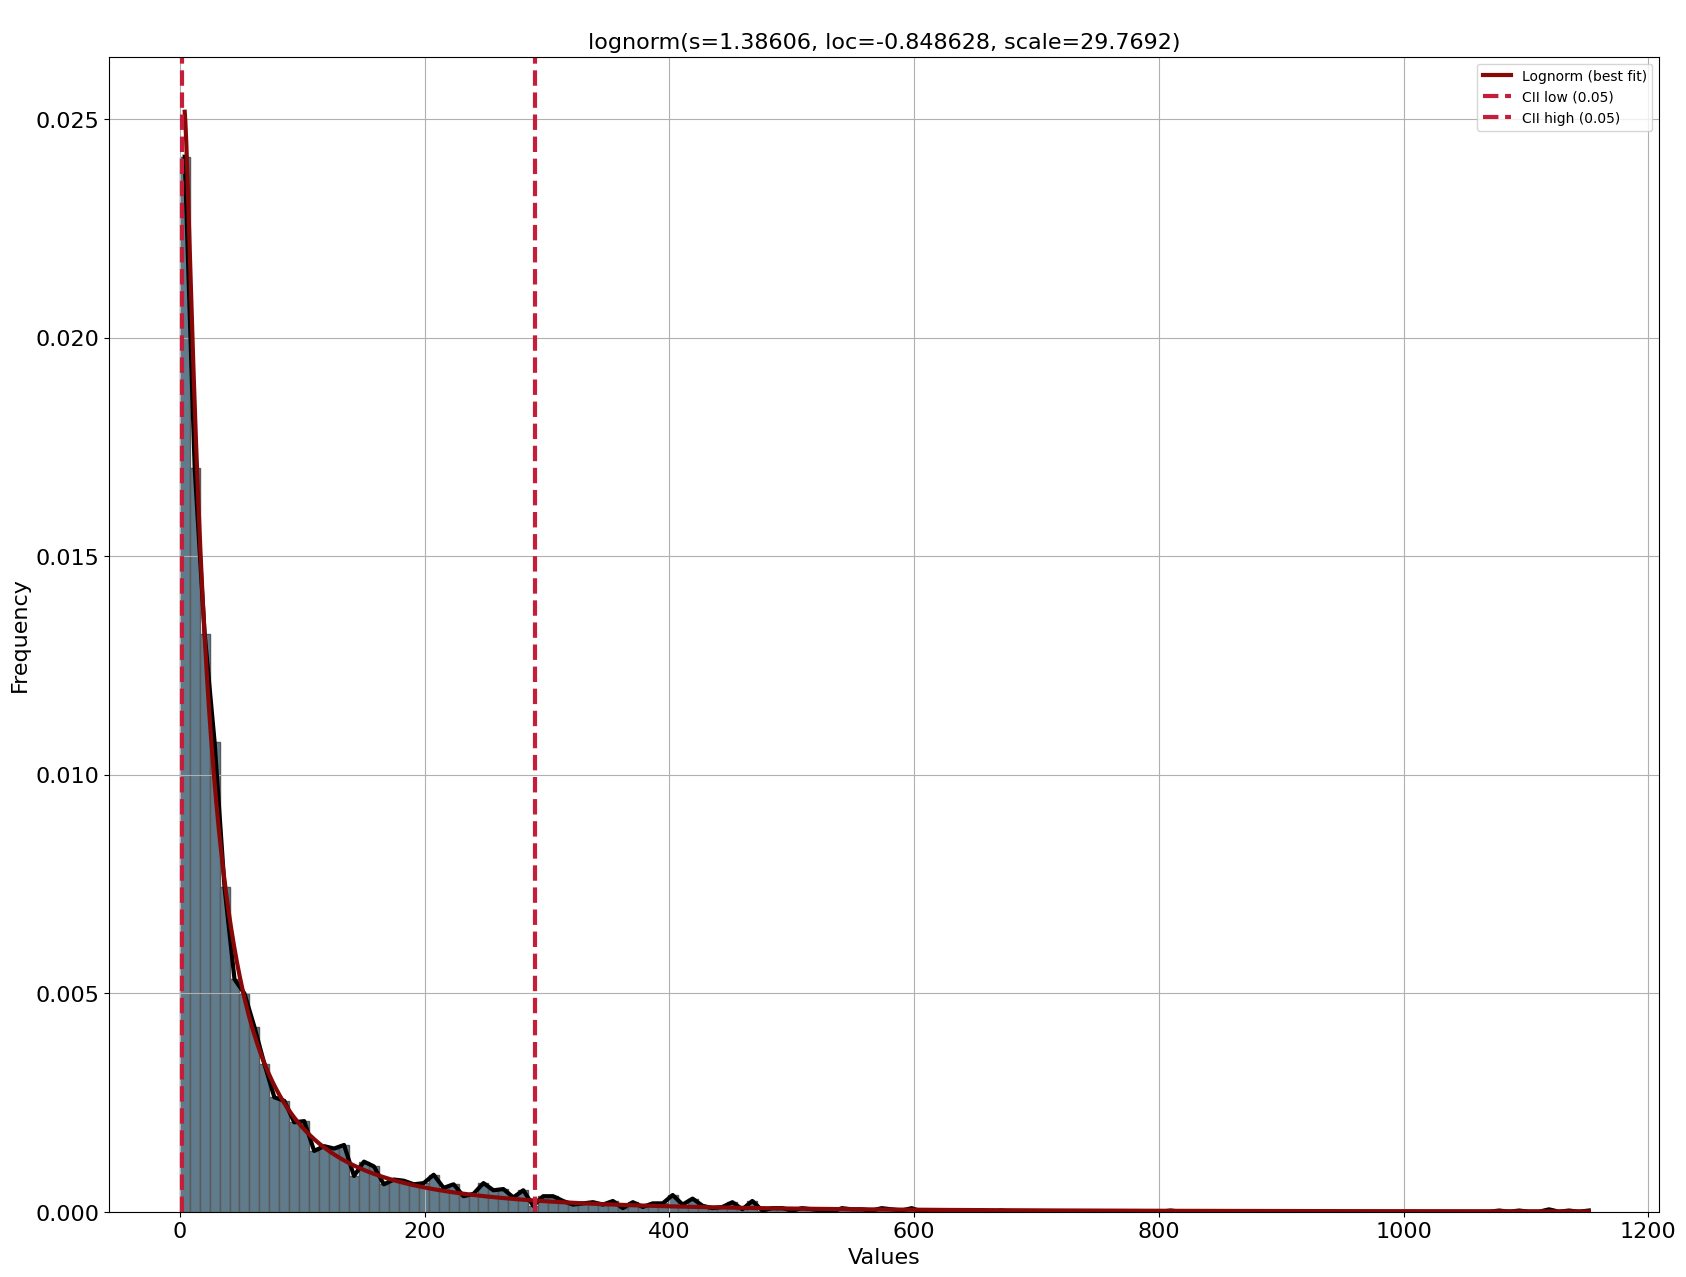

In [21]:
fig, ax = dist_up.plot()

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.000572983] [loc=55.867 scale=71.936]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 1.69165e-05] [loc=0.010 scale=55.857]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 1.58072e-05] [loc=-473.036 scale=473.046]
[distfit] >INFO> [dweibull  ] [0.28 sec] [RSS: 0.000304347] [loc=31.070 scale=36.990]
[distfit] >INFO> [t         ] [0.51 sec] [RSS: 0.00028156] [loc=34.763 scale=28.329]
[distfit] >INFO> [genextreme] [0.36 sec] [RSS: 5.91405e-05] [loc=23.502 scale=23.696]
[distfit] >INFO> [gamma     ] [0.21 sec] [RSS: 0.00143393] [loc=0.010 scale=4.058]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 2.3589e-05] [loc=-2.476 scale=35.959]
[distfit] >INFO> [beta      ] [0.32 sec] [RSS: 1.81712e-05] [loc=0.010 scale=78754.328]
[distfit] >INFO> [uniform   ] [0.0 sec] [RSS: 0.00138575] [loc=0.010 scale=2209.980]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 0.000619488] [loc=-23173.153 scale=3197.454]
[d

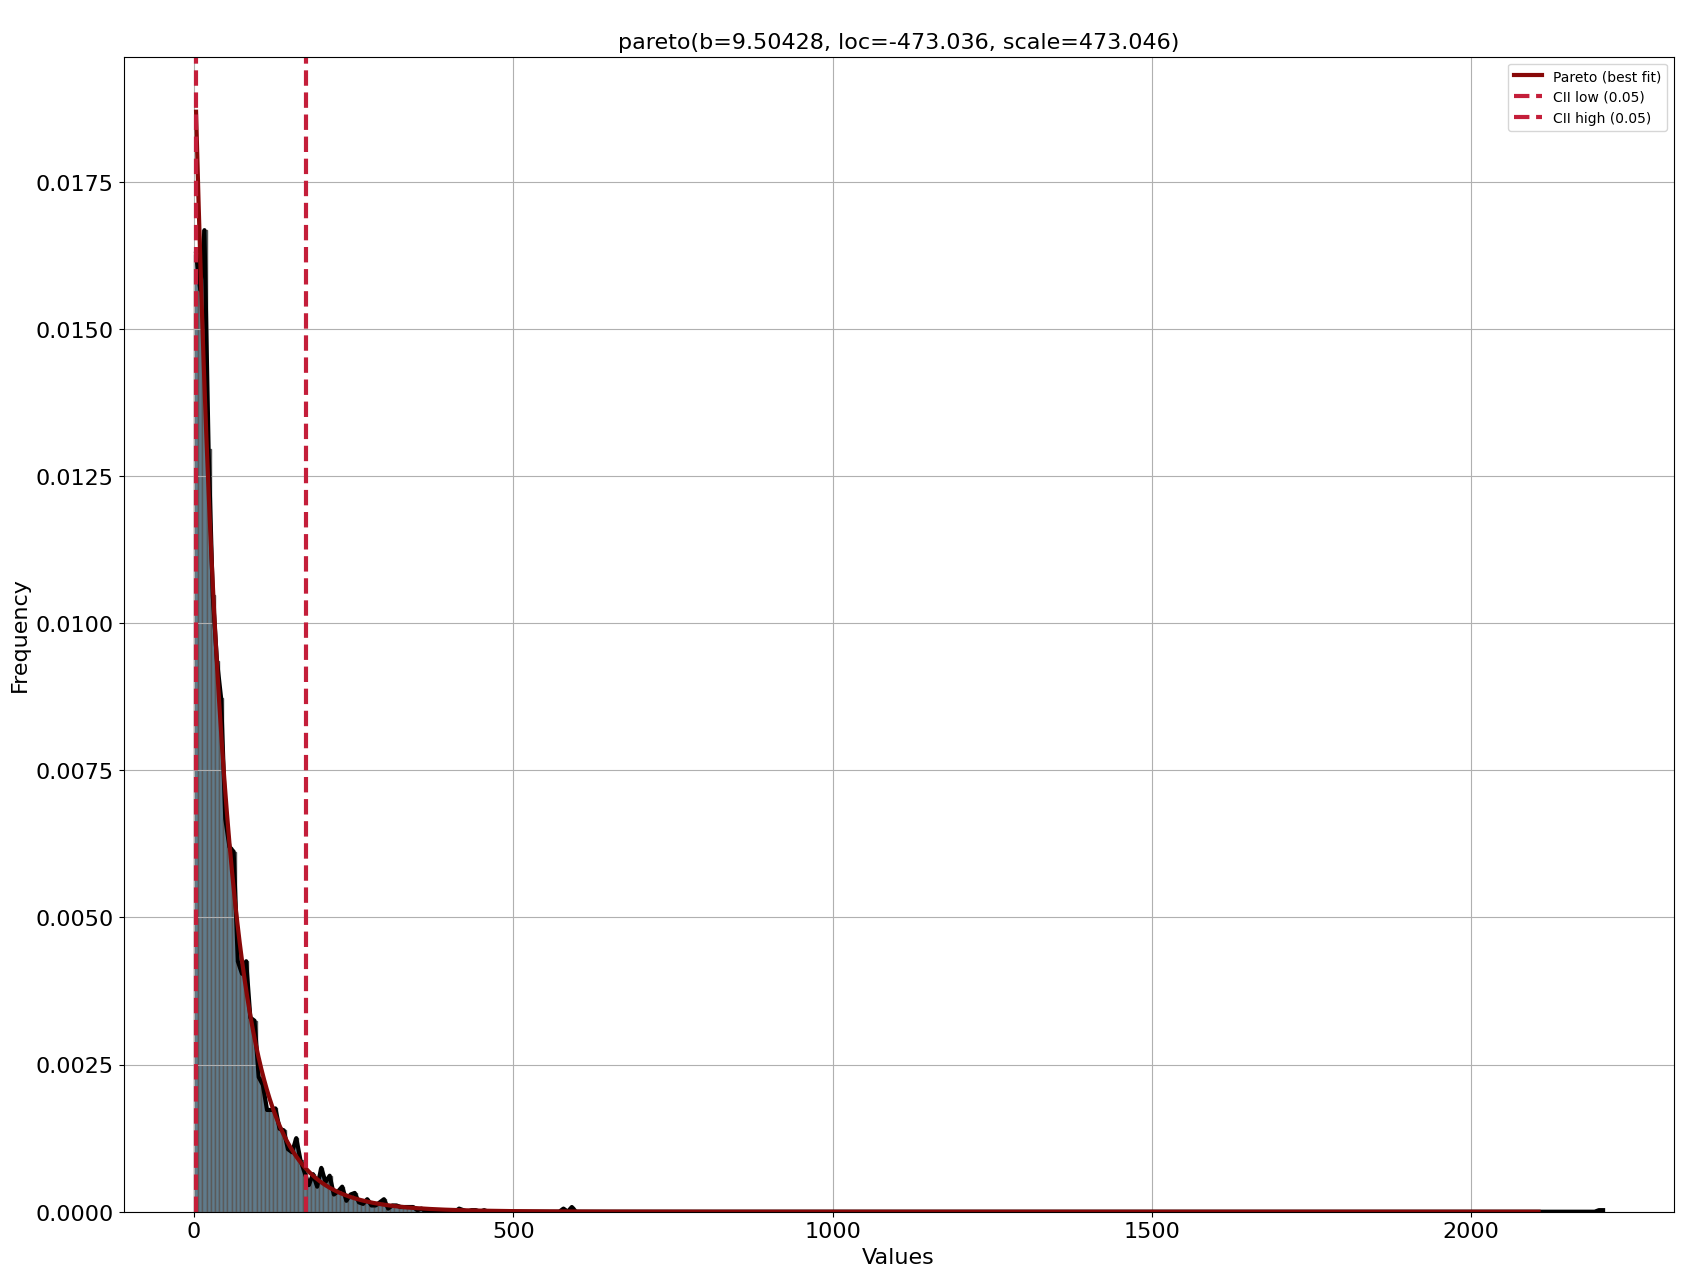

In [22]:
# Fit distributions to each state's data
neg_prices_diff = [-diff for diff in prices_diff[2]]

dist_dw = distfit()
dist_dw.fit_transform(np.array(neg_prices_diff, dtype=float))

fig, ax = dist_dw.plot()

[distfit] >INFO> Create Synthetic data for 1 pareto distributed samples with fitted params (9.504278028161284, -473.0358977653598, 473.04589776535977).
[distfit] >INFO> Create Synthetic data for 1 pareto distributed samples with fitted params (9.504278028161284, -473.0358977653598, 473.04589776535977).
[distfit] >INFO> Create Synthetic data for 1 pareto distributed samples with fitted params (9.504278028161284, -473.0358977653598, 473.04589776535977).
[distfit] >INFO> Create Synthetic data for 1 pareto distributed samples with fitted params (9.504278028161284, -473.0358977653598, 473.04589776535977).
[distfit] >INFO> Create Synthetic data for 1 pareto distributed samples with fitted params (9.504278028161284, -473.0358977653598, 473.04589776535977).
[distfit] >INFO> Create Synthetic data for 1 pareto distributed samples with fitted params (9.504278028161284, -473.0358977653598, 473.04589776535977).
[distfit] >INFO> Create Synthetic data for 1 pareto distributed samples with fitted para

RMSE: 67.10545317555334


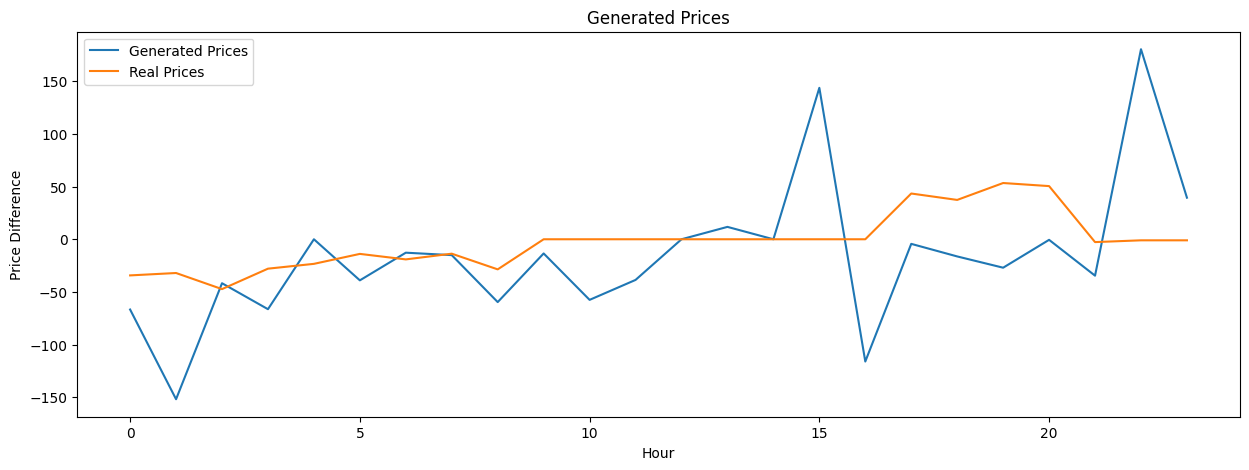

In [28]:
def generate_scenario(num_steps, initial_state, initial_hour, transition_matrices, dist_up, dist_dw):
    states = np.zeros(num_steps + 1, dtype=int)
    states[0] = initial_state
    hour = initial_hour
    prices = np.zeros(num_steps)
    for i in range(1, num_steps + 1):
        state = np.random.choice(3, p=transition_matrices[hour][states[i - 1]])
        states[i] = state
        if state == 0:
            prices[i - 1] = dist_up.generate(1)
        elif state == 2:
            prices[i - 1] = -dist_dw.generate(1)
        hour = (hour + 1) % 24
    return states[1:], prices

# Generate a scenario of states and prices
num_steps = 24
current_state = balancing_states[start_index - 1]
duration = durations[start_index-1]
states, prices = generate_scenario(num_steps, current_state, 0, transition_matrices, dist_up, dist_dw)

print("RMSE:", np.sqrt(np.mean((prices - dataframe['price_diff'][start_index:start_index + num_steps].values) ** 2)))

# Plot the generated prices
plt.figure(figsize=(15, 5))
plt.plot(prices,label='Generated Prices')
plt.plot(dataframe['price_diff'][start_index:start_index + num_steps].values,label='Real Prices')
plt.xlabel('Hour')
plt.ylabel('Price Difference')
plt.title('Generated Prices')
plt.legend()
plt.show()

# ARIMA

In [40]:
# Setup arma models for each state
from statsmodels.tsa.statespace.sarimax import SARIMAX

arma_model_up = SARIMAX(prices_diff[0], order=(3, 0, 2))

arma_model_dw = SARIMAX(prices_diff[2], order=(3, 0, 3))

# Fit the ARMA models
arma_results_up = arma_model_up.fit()
arma_results_dw = arma_model_dw.fit()

# Generate a scenario of states and prices
num_steps = 24
current_state = balancing_states[start_index - 1]
duration = durations[start_index-1]
states = generate_states(num_steps, current_state, 0, transition_matrices)
prices = np.zeros(num_steps)
for i in range(num_steps):
    if states[i] == 0:
        prices[i] = arma_results_up.forecast()
    elif states[i] == 2:
        prices[i] = -arma_results_dw.forecast()
        
print("RMSE:", np.sqrt(np.mean((prices - dataframe['price_diff'][start_index:start_index + num_steps].values) ** 2)))

RMSE: 30.767194070060572


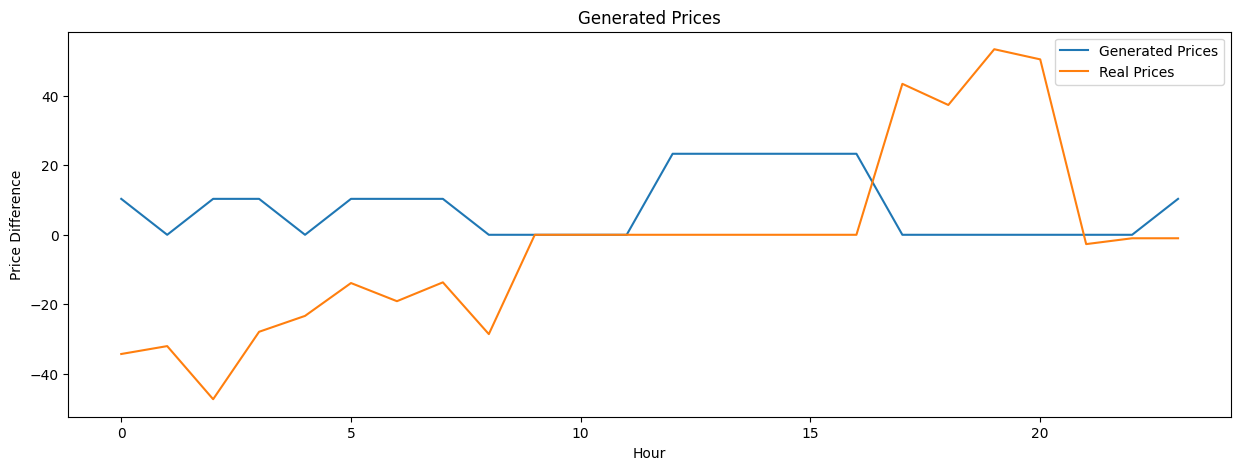

In [41]:
plt.figure(figsize=(15, 5))
plt.plot(prices,label='Generated Prices')
plt.plot(dataframe['price_diff'][start_index:start_index + num_steps].values,label='Real Prices')
plt.xlabel('Hour')
plt.ylabel('Price Difference')
plt.title('Generated Prices')
plt.legend()
plt.show()